# Mushroom Classification Final Notebook

### Harrison Carter
### Flatiron School Data Science NYC Cohort 051622

## Data Preparation

Determining the edibility of mushrooms is of crucial importance in the field. Our field guide uses a data science approach to determine the edibility of any given mushroom within the 173 species provided in the supplementary dataset.

First, import relevant modules and load the dataset.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, roc_curve, plot_roc_curve, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display= 'diagram')

# warnings are disabled for this notebook after completion to increase readability. To turn them on, comment out the following
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/secondary_data.csv', delimiter=';')
df

class  cap-diameter cap-shape cap-surface cap-color  \
0         p         15.26         x           g         o   
1         p         16.60         x           g         o   
2         p         14.07         x           g         o   
3         p         14.17         f           h         e   
4         p         14.64         x           h         o   
...     ...           ...       ...         ...       ...   
61064     p          1.18         s           s         y   
61065     p          1.27         f           s         y   
61066     p          1.27         s           s         y   
61067     p          1.24         f           s         y   
61068     p          1.17         s           s         y   

      does-bruise-or-bleed gill-attachment gill-spacing gill-color  \
0                        f               e          NaN          w   
1                        f               e          NaN          w   
2                        f               e          NaN          w   
3                        f               e          NaN          w   
4                        f               e          NaN          w   
...                    ...             ...          ...        ...   
61064                    f               f            f          f   
61065                    f               f            f          f   
61066                    f               f            f          f   
61067                    f               f            f          f   
61068                    f               f            f          f   

       stem-height  ...  stem-root stem-surface stem-color veil-type  \
0            16.95  ...          s            y          w         u   
1            17.99  ...          s            y          w         u   
2            17.80  ...          s            y          w         u   
3            15.77  ...          s            y          w         u   
4            16.53  ...          s            y          w         u   
...            ...  ...        ...          ...        ...       ...   
61064         3.93  ...        NaN          NaN          y       NaN   
61065         3.18  ...        NaN          NaN          y       NaN   
61066         3.86  ...        NaN          NaN          y       NaN   
61067         3.56  ...        NaN          NaN          y       NaN   
61068         3.25  ...        NaN          NaN          y       NaN   

      veil-color has-ring ring-type spore-print-color habitat season  
0              w        t         g               NaN       d      w  
1              w        t         g               NaN       d      u  
2              w        t         g               NaN       d      w  
3              w        t         p               NaN       d      w  
4              w        t         p               NaN       d      w  
...          ...      ...       ...               ...     ...    ...  
61064        NaN        f         f               NaN       d      a  
61065        NaN        f         f               NaN       d      a  
61066        NaN        f         f               NaN       d      u  
61067        NaN        f         f               NaN       d      u  
61068        NaN        f         f               NaN       d      u  

[61069 rows x 21 columns]

Display all columns for inspection, according to documentation, class is the edibility of the mushroom:

In [3]:
df.columns

Index(['class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'],
      dtype='object')

Visualize numeric predictors effect on class:

''

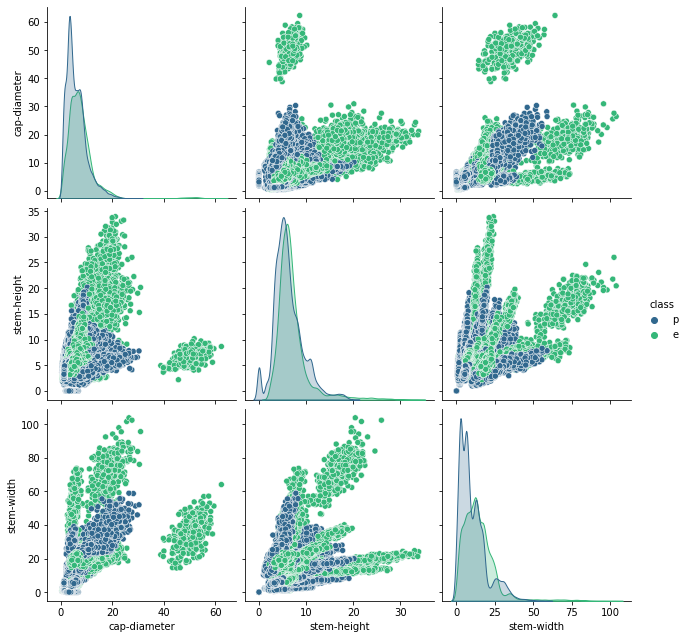

In [4]:
sns.pairplot(df, hue='class', palette='viridis', height=3)
;

Establish X and y variables and split data into train and test groups early to prevent data leakage:

In [5]:
X = df.drop('class', axis=1)
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=63, stratify=y)

Important note:

Dropping columns with high numbers of NA values may seem like the wise thing to do but we do not here. This is for two reasons, the first is that going forward with this model we may encounter a training set that our machine learning model determines is important for classifying edibility. For instance, the final decision tree model does not take into account the spore print color, but when identifying in my leisure time I personally use this metric every time I find a new mushroom. Although this aspect may have some of my own personal bias, leaving them does not hurt the model, leading into the next point. Secondly I'm finding that if you dont impute values for these NAs, sklearn ignores the columns in its modelling anyway (see feature importance after the decision tree model.

## Baseline Model

For the rest of the project, we rely heavily on sklearn's Pipeline to create and assess our models. The first two blocks of code give us the steps that are then run in parallel by combining them under the ColumnTransformer. We then establish our baseline model pipeline and fit it to the training data, and determine the accuracy of the model on training and test data sets.

In [6]:
num_cols = X_train.select_dtypes(['int', 'float']).columns
cat_cols = X_train.select_dtypes(['object']).columns

In [7]:
numeric_pipeline = Pipeline([('numimputer', SimpleImputer(strategy = 'mean')), ('numnorm', StandardScaler())])

nominal_pipeline = Pipeline([
    ('onehotenc', OneHotEncoder(sparse = False, drop = 'first'))])
    
ct = ColumnTransformer([("nominalpipe", nominal_pipeline, cat_cols),
                        ("numpipe", numeric_pipeline, num_cols)])
                        #,('ordpipe', ordinal_pipeline, ord_cols)])

model_pipe1 = Pipeline([('preprocess', ct),('model', LogisticRegression(max_iter=400, random_state=13))])

model_pipe1.fit(X_train,y_train)
print('train score: {}'.format(model_pipe1.score(X_train,y_train)))
print('test score: {}'.format(model_pipe1.score(X_test,y_test)))
model_pipe1

train score: 0.8661892658128849
test score: 0.8659256686349427


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  Index(['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed',
       'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root',
       'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring',
       'ring-type', 'spore-print-color', 'habitat', 'season'],
      dtype='object')),
                                                 ('numpipe',
                                                  Pipeline(steps=[('numimputer',
                                                                   SimpleImputer()),
                                                                  ('numnorm',
                                                                   StandardScaler())]),
                                                  Index(['cap-diameter', 'stem-height', 'stem-width'], dtype='object'))])),
                ('model', LogisticRegression(max_iter=400, random_state=13))])

Above is a neat visualization of the pipeline workflow. Below is the baseline confusion matrix, ROC curve, and classification report.

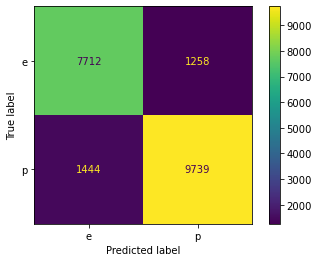

In [8]:
plot_confusion_matrix(model_pipe1, X_test, y_test);

''

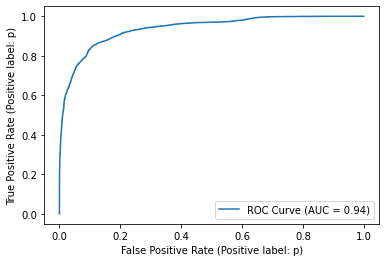

In [9]:
roc = plot_roc_curve(model_pipe1, X_test, y_test, name='ROC Curve')
;

In [10]:
y_pred1 = model_pipe1.predict(X_test)
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           e       0.84      0.86      0.85      8970
           p       0.89      0.87      0.88     11183

    accuracy                           0.87     20153
   macro avg       0.86      0.87      0.86     20153
weighted avg       0.87      0.87      0.87     20153



The model is surprisingly good for a baseline, but we need to ensure we increase recall. This is because false negatives in this case represent mushrooms that are classified as edible but are in fact poisonous. We will need a model with a better score, and then we also need to increase the threshold to reduce our false negatives.

## Decision Tree

Lets try a decision tree model. This can be done by replacing the logistic regression in the pipeline easily.

In [11]:
tree_clf = DecisionTreeClassifier(max_depth=50,random_state=13)

model_tree = Pipeline([('preprocess', ct), ('d_tree', tree_clf)])
model_tree.fit(X_train, y_train)

print('Training:', model_tree.score(X_train, y_train))
print('Testing:', model_tree.score(X_test, y_test))

Training: 1.0
Testing: 0.9986106286905175


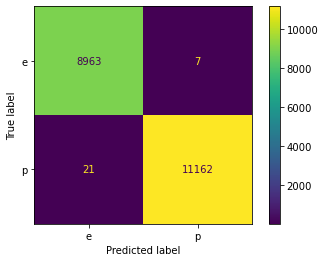

In [12]:
plot_confusion_matrix(model_tree, X_test, y_test);

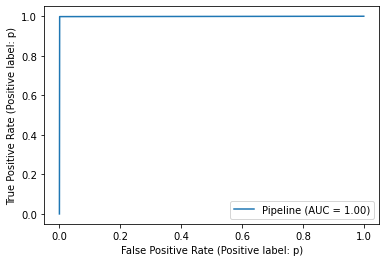

In [13]:
plot_roc_curve(model_tree, X_test, y_test);

This model is a huge improvement over the baseline.

To improve on this, we will try a Random Forest model. The Random Forest model 

Note: going forward I am going to include a timer on the models to give an idea of how long these computations take, which I find fascinating.

In [14]:
f, ax = plt.subplots(figsize=(250, 250))
plot_tree(tree_clf, ax=ax);

In [15]:
feature_used = X.columns

for fi, feature in zip(tree_clf.feature_importances_, feature_used):
    print(fi, feature)

0.024647358438246645 cap-diameter
0.005221908129653214 cap-shape
0.00037108135782522696 cap-surface
0.0 cap-color
0.002284908057904188 does-bruise-or-bleed
0.02469803511093036 gill-attachment
0.018916760366939164 gill-spacing
0.02905579431851471 gill-color
0.0008142859283390404 stem-height
0.006174793794211776 stem-width
0.0 stem-root
0.02285776826032805 stem-surface
0.021873337455120313 stem-color
0.009788225688639239 veil-type
0.0 veil-color
0.012271193582965488 has-ring
0.03100783888536614 ring-type
1.385125968553048e-05 spore-print-color
0.0019916175889171774 habitat
0.0004884877136098007 season


## Random Forest

In [16]:
# start timer
starttime = time.time()
print('Start timer')

rf_param_grid = {'preprocess__numpipe__numimputer__strategy': ['mean'],
    'randfor__n_estimators': [10, 30, 65, 100],
    'randfor__criterion': ['gini', 'entropy'],
    'randfor__max_depth': [None, 2, 6, 10],
    'randfor__min_samples_split': [5, 10],
    'randfor__min_samples_leaf': [3, 6]
}

rf = RandomForestClassifier()

model_rf = Pipeline([('preprocess', ct), ('randfor', rf)])

gs_pipe_rf = GridSearchCV(estimator=model_rf, 
                       param_grid=rf_param_grid)

gs_pipe_rf.fit(X_train, y_train)

print('train score: {}'.format(gs_pipe_rf.score(X_train,y_train)))
print('test score: {}'.format(gs_pipe_rf.score(X_test,y_test)))

# end timer
endtime = time.time()

# display time elapsed
converttime = time.strftime("%H:%M:%S", time.gmtime(endtime - starttime))
print('Time elapsed: {}'.format(converttime))

Start timer
train score: 1.0
test score: 0.9999503795960899
Time elapsed: 00:09:53


In [17]:
gs_pipe_rf.best_params_

{'preprocess__numpipe__numimputer__strategy': 'mean',
 'randfor__criterion': 'entropy',
 'randfor__max_depth': None,
 'randfor__min_samples_leaf': 3,
 'randfor__min_samples_split': 10,
 'randfor__n_estimators': 30}

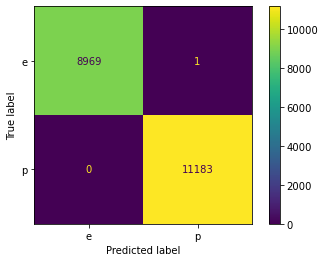

In [18]:
plot_confusion_matrix(gs_pipe_rf, X_test, y_test)

This model is almost exactly what we want. We only need to eliminate this false negative by tuning the decision threshold, which I will need to consult a data scientist to determine an appropriate value for. We know it will be greater than 0.5 and less than 1 but this is a very delicate part of the model that requires an informed decision. Typically, this is calculated by finding the harmonic mean between precision and recall scores, but here we want to favor recall. Arbitrarily increasing this value could invalidate the model.

Note: depending on how the random state that I couldn't pinpoint turns out, this false negative may dissapear in place of a false positive. Because this results from a random state change, the point above still stands.

## KNN

Using KNN here may seem counterintuitive. When the dimensionality of the dataset goes up (more predictor columns), KNN takes exponentially longer to calculate due to each extra dimension adding another dimension of distance to calculate. The following grid search is by far the longest calculation we make, taking approximately 31 minutes. 

In [19]:
# start timer
starttime = time.time()
print('Start timer')

# hyperparameter tuning
pipe_grid_knn = {'preprocess__numpipe__numimputer__strategy': ['mean', 'median', 'most_frequent'],
             'knn__n_neighbors': [2, 3, 5, 7],
             'knn__p': [1, 2]}

model_knn = Pipeline([('preprocess', ct),('knn', KNeighborsClassifier())])
model_knn.fit(X_train, y_train)

# note: default scoring is accuracy
gs_pipe_knn = GridSearchCV(estimator=model_knn, 
                       param_grid=pipe_grid_knn)

gs_pipe_knn.fit(X_train, y_train)
print('train score: {}'.format(gs_pipe_knn.score(X_train,y_train)))
print('test score: {}'.format(gs_pipe_knn.score(X_test,y_test)))

# end timer
endtime = time.time()

# display time elapsed
converttime = time.strftime("%H:%M:%S", time.gmtime(endtime - starttime))
print('Time elapsed: {}'.format(converttime))

Start timer
train score: 1.0
test score: 1.0
Time elapsed: 00:56:40


In [20]:
gs_pipe_knn.best_params_

{'knn__n_neighbors': 2,
 'knn__p': 1,
 'preprocess__numpipe__numimputer__strategy': 'mean'}

Interestingly, we can create here a model with perfect accuracy and recall. For this and any generative data from the original 173 mushrooms, this model should perform at maximum recall. For full grown regular mushrooms of these species found in the wild this model should also perform extremely well.

## Final Tuned Model

The following is the final model with the optimal hyperparameters for this data.

In [21]:
# start timer
starttime = time.time()
print('Start timer')

# Narrow down hyperparameters to make a quicker grid search
pipe_grid_final = {'preprocess__numpipe__numimputer__strategy': ['mean'],
             'knn__n_neighbors': [2],
             'knn__p': [1]}

gs_pipe_final = GridSearchCV(estimator=model_knn, 
                       param_grid=pipe_grid_final)

gs_pipe_final.fit(X_train, y_train)
print('train score: {}'.format(gs_pipe_final.score(X_train,y_train)))
print('test score: {}'.format(gs_pipe_final.score(X_test,y_test)))

# end timer
endtime = time.time()

# display time elapsed
converttime = time.strftime("%H:%M:%S", time.gmtime(endtime - starttime))
print('Time elapsed: {}'.format(converttime))

Start timer
train score: 1.0
test score: 1.0
Time elapsed: 00:05:50


To ensure the model does indeed work, lets create some fake test data containing twenty known mushrooms, one of which is misclassified. The test score should then be 0.95 or 95% accuracy (19/20 = 0.95).

In [23]:
# sanity check

# start timer
starttime = time.time()
print('Start timer')

X_test_fakes = X_test[:][:20]
y_test_fakes = y_test[:][:20]
if y_test_fakes.loc[y_test_fakes.index[0]] == 'e':
    y_test_fakes.loc[y_test_fakes.index[0]] = 'p'
elif y_test_fakes.loc[y_test_fakes.index[0]] == 'p':
        y_test_fakes.loc[y_test_fakes.index[0]] = 'e'

print('test score: {}'.format(gs_pipe_final.score(X_test_fakes,y_test_fakes)))

# end timer
endtime = time.time()

# display time elapsed
converttime = time.strftime("%H:%M:%S", time.gmtime(endtime - starttime))
print('Time elapsed: {}'.format(converttime))

Start timer
test score: 1.0
Time elapsed: 00:00:00


The limitations of this model are that because the data is generative from healthy adult mushrooms, it may not work on samples that are in a different stage of growth, stunted, diseased, etc. While these samples would generally be considered noise, the model is essentially only trained on signal, so it may not classify them well. We do not know until we try.